In [1]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

from matplotlib import cm
from scipy import integrate
# from itertools import combinations
# from math import factorial

%matplotlib inline

In the [Chernoff et al 2020 paper](https://ui.adsabs.harvard.edu/abs/2020MNRAS.491..596C/abstract) equation 12 gives the microlensing rate per star per second: 

$\frac{\Gamma}{N_\star} = \int_0^D dr' dl \left(\frac{dn}{dl}\right)'\langle \frac{dA_\perp}{dt} \rangle$.

I use $\langle \frac{dA_\perp}{dt} \rangle = 0.2 lc$.

I take $\left(\frac{dn}{dl}\right)'$ to be $\frac{1}{l}\mathcal{F}(r')\,\mathcal{G}\,\left(\frac{dn}{d\ln{l}}\right)_\text{base}$, as in Equation 3, which invokes clustering via $\mathcal{F}$. In their paper, $\mathcal{G} = 10^2$ as stated in the first paragraph on page 598, and equation 1 states that:

$\left(\frac{dn}{d\ln{l}}\right)_\text{base} = 1.15 \times 10^{-6} \frac{x}{(1+x)^{5/2}} \frac{f_{0.2}\alpha_{0.1}^{1/2}}{(\Gamma_{50}\mu_{-13})^{3/2}} \text{kpc}^{-3}$,

where $\mu_{-13} = \frac{G \mu}{c^2} \times 10^{13}$, $x = \frac{l}{l_g}$, $l_g = 0.0206 \, \Gamma_{50} \, \mu_{-13}$ pc, and $\Gamma_{50} = f_{0.2} = \alpha_{0.1} = 1$. The clustering enhancement 

$\mathcal{F}(r) = \max \left(\beta(\mu)\mathcal{E}(r), 1\right) = \max\left(\beta(\mu) \frac{\rho_{DM}(r)}{\Omega_{DM} \rho_{\text{crit}}}, 1\right)$ 

is defined in the second paragraph on the right side of page 599. $\max$ is used to ensure that $\mathcal{F} \geq 1$ always. The functional form of $\beta(\mu)$ is given in Appendix F of [Chernoff and Tye's 2018 paper](https://arxiv.org/pdf/1712.05060.pdf). $\mathcal{E} = \frac{\rho_{DM}(r)}{\Omega_{DM} \rho_{\text{crit}}}$ is defined in equation 5: 

$ \rho_{\text{MW - M31}} = \begin{cases}
\frac{A}{r^{9/4}} & 0 < r < r_1 \\ 
\frac{2^{3/4}A}{(B-r)^{9/4}} & r_1 < r < B
\end{cases} $

where $A = 1.15 \times 10^9 M_\odot / \text{kpc}^{3/4}$, $r_1 = 345$ kpc, and $B = 780$ kpc. I use $\Omega_{DM} = 1/4$ and $\rho_{\text{crit}} = 3 H_0^2/8\pi G$. Finally, I place the observer 8 kpc from the Milky Way center and the source 8 kpc in front of the center of M31, as indicated in table 1 of the 2020 paper.

Combining all this gives:

$\frac{\Gamma}{N_\star} = \int_8^{772}dr' \int_0^\infty dl \, \frac{1}{l}\, \mathcal{F}(r) \, \mathcal{G}\, 1.15 \times 10^{-6} \, \frac{x}{(1+x)^{5/2}} \, \frac{f_{0.2}\alpha_{0.1}^{1/2}}{(\Gamma_{50}\mu_{-13})^{3/2}} \, \text{kpc}^{-3}  lc$

Cancelling the factors of $l$ and using $dl = l_g dx$ gives:

$\frac{\Gamma}{N_\star} = \int_8^{772}dr' \int_0^\infty dx l_g \, c \, \mathcal{F}(r) \, \mathcal{G}\, 1.15 \times 10^{-6} \, \frac{x}{(1+x)^{5/2}} \, \frac{f_{0.2}\alpha_{0.1}^{1/2}}{(\Gamma_{50}\mu_{-13})^{3/2}} \, \text{kpc}^{-3} $.

the $x$ integral gives:

$\int_0^\infty dx \frac{x}{(1+x)^{(5/2)}} = 4/3$.

Finally we have

$\frac{\Gamma}{N_\star} = l_g \, c \, 
\mathcal{G} \, 1.15 \times 10^{-6} \, \frac{4}{3} \, \frac{f_{0.2}\alpha_{0.1}^{1/2}}{(\Gamma_{50}\mu_{-13})^{3/2}} \, \int_8^{772} dr \mathcal{F}(r) \, \text{kpc}^{-3} $

In [2]:
class EventCalculator():
    _f02 = 1
    _a01 = 1
    _gamma50 = 1
    _newtonG = 6.674e-11 * u.newton * u.m**2 / u.kg**2
    _speedOfLight = 2.98e8 * u.m / u.s
    _internalMotionRMS = _speedOfLight / 2

    @property
    def newtonG(self):
        return self._newtonG
    @property
    def speedOfLight(self):
        return self._speedOfLight
    
    @property
    def internalMotionRMS(self):
        return self._internalMotionRMS
    
    @property
    def f02(self):
        return self._f02

    @property
    def a01(self):
        return self._a01

    @property
    def gamma50(self):
        return self._gamma50

    def set_f02(self, f02):
        self._f02 = f02

    def set_a01(self, a01):
        self._a01 = a01

    def set_gamma50(self, gamma50):
        self._gamma50 = gamma50

    def __init__(self, configDict):
        self.tensions = configDict.get("tensions", np.logspace(-15, -8, num=8))
        self.curlyG = configDict.get("curlyG", 1e2)
        self.dmHaloA = configDict.get("dmHaloA", 1.15e9 * u.solMass / u.kpc**(3/4))
        self.dmHaloR1 = configDict.get("dmHaloR1", 345 * u.kpc)
        self.dmHaloC = configDict.get("dmHaloC", 2**(3/4))
        self.hostGalaxyCenter = configDict.get("hostGalaxyCenter", np.array([780, 0]) * u.kpc)
        self.observerGalaxyCenter = configDict.get("observerGalaxyCenter", np.array([0, 0]) * u.kpc)
        self.observerPosition = configDict.get("observerPosition", np.array([8, 0]) * u.kpc)
        self.sourcePosition = configDict.get("sourcePosition",
                                             self.hostGalaxyCenter + np.array([0, 8]) * u.kpc)
        self.impactParameter = configDict.get("impactParameter", np.array([0, 0]) * u.kpc)

        self.results = dict(eventRates = None,
                            dmRho = None,
                            lineOfSight = None,
                            enhancementFactor = None,
                            rStepSize = None)

    @staticmethod
    def _foo(y):
        return -0.337 - (0.064 * y**2)

    def betaOfMu(self):
        return 10**self._foo(np.log10(self.tensions * 1e15))

    def _calculateEnhancementFactor(self):
        littleHubble = 0.7
        bigHubble = littleHubble * 100 * u.km / u.s / u.Mpc
        newtonG = 6.674e-11 * u.newton * u.m**2 / u.kg**2
        rhoCritical = 3 * bigHubble**2 / (8 * np.pi * newtonG)
        omegaDM = 1/4
        overdensityDM = self.results["dmRho"] / (omegaDM * rhoCritical)
        betas = self.betaOfMu()
        # Column of betas to take advantage of python broadcasting
        betas = betas.reshape(len(betas), 1)

        # tempF can have values less than 1
        tempF = (betas * overdensityDM).decompose()

        # invoking np.where so the enhancement is never less than homogeneous limit (ie 1)
        self.results["enhancementFactor"] = np.where(tempF > 1, tempF, 1)

    def calculate(self, nSteps=10000):
        mu13 = self.tensions * 1e13
        speedOfLight = 2.98e8 * u.m / u.s
        xIntegral = 4/3
        f02 = self.f02
        a01 = self.a01
        gamma50 = self.gamma50
        lg = 0.0206 * gamma50 * mu13 * u.pc

        self._modelDMRho(nSteps=nSteps)
        self._calculateEnhancementFactor()

        # Integrate F(r)dr
        enhancementIntegral = integrate.trapz(self.results["enhancementFactor"],
                                              axis=1, dx=self.results["rStepSize"])
        eventRates = (0.2 * lg * speedOfLight * self.curlyG * 1.15e-6 * xIntegral
                     * (f02 * np.sqrt(a01) / (gamma50 * mu13)**(3/2)) *
                     enhancementIntegral * u.kpc**(-3))
        self.results["eventRates"] = eventRates

    def _modelDMRho(self, nSteps=10000):
        hostGalaxyCenter = self.hostGalaxyCenter
        impactParameter = self.impactParameter
        observerPosition = self.observerPosition
        sourcePosition = self.sourcePosition
        r1 = self.dmHaloR1
        dmHaloA = self.dmHaloA
        dmHaloC = self.dmHaloC

        # Scoot the hostGalaxy along y axis to avoid diverging center if needed
        hostGalaxyCenterPrime = (hostGalaxyCenter + impactParameter).reshape(2, 1)
        self.results["lineOfSight"] = np.array([np.linspace(observerPosition[0],
                                                            sourcePosition[0],
                                                            num=nSteps).to(u.kpc),
                                                np.linspace(observerPosition[1],
                                                            sourcePosition[1],
                                                            num=nSteps).to(u.kpc)]) * u.kpc

        r = self.results["lineOfSight"]
        # Norm each vector
        rNorm = np.linalg.norm(r, axis=0)
        self.results["rStepSize"] = np.linalg.norm(r[:, 1] - r[:, 0])

        # rPrime is vector from MW center ([0, 0]) when within r1,
        # vector from hostGalaxyCenterPrime otherwise
        rPrime = np.where(rNorm < r1, r, r - hostGalaxyCenterPrime)
        rPrimeNorm = np.linalg.norm(rPrime, axis=0)
        self.results["dmRho"] = np.where(rNorm < r1, dmHaloA / rPrimeNorm**(9/4),
                                         dmHaloC * dmHaloA / rPrimeNorm**(9/4))

    def plotEnhancement(self, title=None, xUnits="kpc"):
        fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12, 8))
        colors = cm.gist_rainbow(np.linspace(0, 1, num=len(self.tensions)))
        
        enhancement = self.results["enhancementFactor"]
        x = self.results["lineOfSight"]

        for f, t, c in zip(enhancement, self.tensions, colors):
            ax.semilogy(np.linalg.norm(x, axis=0), f, label=f"{t}", color=c)
            ax.set_ylabel(r"Enhancement Factor $\mathcal{F}(r)$", fontsize=18)

        ax.legend(fontsize=14)

        if title is not None:
            fig.suptitle(title, fontsize=24)
        ax.set_xlabel(f"Distance Along Line of Sight ({xUnits})", fontsize=18)
        ax.tick_params(labelsize=16)
        plt.show(fig)
        
    def sampleDistances(self, seed=None, nSamples=10000, plot=False, **kwargs):
        cdf = (np.cumsum(self.results["enhancementFactor"], axis=1) / 
               self.results["enhancementFactor"].sum(axis=1).reshape(8, 1))
        
        distanceFromObserver = (self.results["lineOfSight"] -
                                self.results["lineOfSight"][0])
        distanceFromObserver = np.linalg.norm(distanceFromObserver, axis=0)
        distanceFromObserverTiled = np.tile(distanceFromObserver, (8, 1))
        
        rng = np.random.default_rng(seed=seed)
        samples = rng.random(size=nSamples)

        distanceSamples = np.array([getFirstGoodElementInEachRow(distanceFromObserverTiled, cdf > s)
                                    for s in samples])
        distanceSamples = distanceSamples.transpose() * u.kpc
        
        if plot:
            fig, ax = plt.subplots(figsize=(12, 10))
            colors = cm.gist_rainbow(np.linspace(0, 1, num=len(self.tensions)))

            for y, t, c in zip(distanceSamples, self.tensions, colors):
                ax.hist(y, bins=np.linspace(distanceFromObserver[0], distanceFromObserver[-1], num=100),
                        histtype="step", label=f"{t}", log=True, color=c, **kwargs)

            ax.legend(fontsize=15, loc="upper left")
            ax.set_xlabel("Distance Along Line of Sight (kpc)", fontsize=18)
            ax.tick_params(labelsize=15)
            plt.show(fig)

        return distanceSamples
    
    def computeSourceDistance(self):
        return np.linalg.norm(self.sourcePosition - self.observerPosition)
    
    def computeMaximumLensingTimes(self, stringTheta=np.pi/4):
        sourceDistance = self.computeSourceDistance()
        deficitAngles = 8 * np.pi * self.tensions
        return (sourceDistance * deficitAngles * np.sin(stringTheta) / (4 * self.internalMotionRMS)).decompose()
        
    def computeLensingTimeSamples(self, distanceSamples, stringTheta=np.pi/4):
        sourceDistance = self.computeSourceDistance()
        deficitAngles = 8 * np.pi * self.tensions.reshape(8, 1)
        timeSamples = (deficitAngles * np.sin(stringTheta) * distanceSamples 
                       * (1 - (distanceSamples / sourceDistance)) / self.internalMotionRMS).decompose()
        return timeSamples
        
class ExperimentExpectationsCalculator():
    def __init__(self, experimentParameters, eventCalculator):
        self.observingHoursPerNight = experimentParameters.get("observingHoursPerNight", 8 * u.hr)
        self.filters = experimentParameters.get("filters", ["u", "g", "r", "i", "z", "y"])
        self.visitsInEachFilter = experimentParameters.get("visitsInEachFilter",
                                                           np.array([45, 67, 183, 191, 167, 168]))
        self.detectionThreshold = experimentParameters.get("detectionThreshold", 0.9)
        self.experimentDuration = experimentParameters.get("experimentDuration", 10 * u.yr)
        self.exposureTime = experimentParameters.get("exposureTime", 30 * u.s)
        self.readoutTime = experimentParameters.get("readoutTime", 2 * u.s)
        self.exclusionThreshold = experimentParameters.get("exclusionThreshold", 1e-5)
        self.hostGalaxySolidAngle = experimentParameters["hostGalaxySolidAngle"]
        self.eventCalculator = eventCalculator
        self.results = dict(observableWindowDurations = None,
                            probeableTensions = None,
                            eventProbabilities = None,
                            atLeastOneImageProbabilities = None,
                            detectionProbabilities = None,
                            nStarsRequired = None)
        
    def calculate(self, quantile=None, nSamples=10000, seed=None):
        if quantile is None:
            lensingTimes = self.eventCalculator.computeMaximumLensingTimes()
            lamFactor = 1
        else:
            distanceSamples = self.eventCalculator.sampleDistances(seed=seed, nSamples=nSamples)
            timeSamples = self.eventCalculator.computeLensingTimeSamples(distanceSamples)
            lensingTimes = np.quantile(timeSamples, quantile, axis=1)
            lamFactor = (1 - quantile)
        
        nVisitsAll = self.visitsInEachFilter.sum()
        experimentDuration = self.experimentDuration
        surveyDuration = experimentDuration * self.observingHoursPerNight / (24 * u.hr)
        visitTime = self.exposureTime + self.readoutTime
        detectableTime = experimentDuration - 2 * self.detectionThreshold * visitTime
        totalTimes = lensingTimes + detectableTime
        
        observableWindowDurations = (lensingTimes + (1 - 2 * self.detectionThreshold)
                                     * self.exposureTime).decompose()
        averageOverlapTime = ((lensingTimes * totalTimes) /
                              (lensingTimes + totalTimes))
        averageObservableTime = (averageOverlapTime * self.observingHoursPerNight / (24 * u.hr))
        
        probeable = np.logical_and(observableWindowDurations > 0,
                           averageOverlapTime < 0.9 * experimentDuration)
        
        probeableTensions = self.eventCalculator.tensions[probeable]
        observableWindowDurations = observableWindowDurations[probeable]
        averageObservableTime = averageObservableTime[probeable]
        totalTimes = totalTimes[probeable]
        
        lam = (lamFactor * self.eventCalculator.results["eventRates"][probeable] 
               * totalTimes).decompose()
        eventProbabilities = 1 - np.exp(-lam)
        
        unlensedTimeInYrs = (surveyDuration - averageObservableTime).to(u.yr).value
        visitTimeInYrs = visitTime.to(u.yr).value
        surveyDurationInYrs = surveyDuration.to(u.yr).value

        missEventProbabilitiesJthExposure = np.array([((unlensedTimeInYrs - j * visitTimeInYrs) / 
                                                       (surveyDurationInYrs - j * visitTimeInYrs))
                                                      for j in range(nVisitsAll)])
        missEventProbabilitiesJthExposure = np.where(missEventProbabilitiesJthExposure > 0,
                                                     missEventProbabilitiesJthExposure, 0)
        missEventProbabilities = np.prod(missEventProbabilitiesJthExposure, axis=0)

        atLeastOneImageProbabilities = 1 - missEventProbabilities
        detectionProbabilities = eventProbabilities * atLeastOneImageProbabilities
        nStarsRequired = np.log(self.exclusionThreshold) / np.log(1 - detectionProbabilities)

        self.results["observableWindowDurations"] = observableWindowDurations
        self.results["probeableTensions"] = probeableTensions
        self.results["eventProbabilities"] = eventProbabilities
        self.results["atLeastOneImageProbabilities"] = atLeastOneImageProbabilities
        self.results["detectionProbabilities"] = detectionProbabilities
        self.results["nStarsRequired"] = nStarsRequired
        
    def plotResults(self, title=None, figure=None, show=True, **kwargs):
        if figure is None:
            figure, axs = plt.subplots(4, 1, figsize=(15, 12), sharex=True)
        else:
            axs = figure.axes
            assert len(axs) == 4, f"Figure must have 4 axes but instead has {len(axs)}."
            
        ys = [self.results["eventProbabilities"],
              self.results["atLeastOneImageProbabilities"],
              self.results["detectionProbabilities"],
              self.results["nStarsRequired"]]

        titles = ["Event Probabilities", "Probability of Getting at Least One Image",
                  "Detection Probability",
                  f"Number of Stars Required for P(No Detection) = {self.exclusionThreshold}"]

        for y, t, ax in zip(ys, titles, axs):
            ax.loglog(self.results["probeableTensions"], y, **kwargs)
            ax.set_title(t, fontsize=20)
            ax.tick_params(labelsize=14)
            ax.grid(visible=True)

        axs[-1].set_xlabel(r"G$\mu/c^2$", fontsize=17)
        axs[0].legend(fontsize=14)
        
        if title is not None:
            figure.suptitle(title, fontsize=24)
        
        if show:
            plt.show(figure)
            
    def plotStarsPerPSF(self, psfFWHM, title=None, figure=None, show=True, **kwargs):
        if figure is None:
            figure, ax = plt.subplots(figsize=(12, 10))
        else:
            ax = figure.axes[0]

        y = (np.sqrt(self.results["nStarsRequired"] / self.hostGalaxySolidAngle)
             * psfFWHM).decompose()

        x = self.results["probeableTensions"]

        ax.loglog(x, y, **kwargs)

        ax.legend(fontsize=16)
        ax.tick_params(labelsize=14)
        ax.grid(visible=True)
        ax.set_xlabel(r"G$\mu/c^2$", fontsize=17)
        ax.set_ylabel("Stars per PSF FWHM", fontsize=17)

        if title is not None:
            fig.suptitle(title, fontsize=24)

        if show:
            plt.show(fig)

        
def calculateHaloValues(hostGalaxyDistance, galaxyMassRatio):
    haloR1 = (galaxyMassRatio**(1/3) / (1 + galaxyMassRatio**(1/3))) * hostGalaxyDistance
    haloC = ((hostGalaxyDistance - haloR1) / haloR1)**(9/4)
    return haloR1, haloC

def getFirstGoodElementInEachRow(matrix, mask):
    rows, columns = np.where(mask)
    uniqueRows, uniqueIdxs = np.unique(rows, return_index=True)
    uniqueColumns = columns[uniqueIdxs]
    return matrix[uniqueRows, uniqueColumns]
        
# def filterTupleToVector(filterTuple, nFilters):
#     z = np.zeros(nFilters)
#     np.put(z, filterTuple, 1)
#     return z

# def multinomialPDF(x, p):
#     n = x.sum()
#     return (factorial(n) / (np.prod([factorial(xx) for xx in x]))) * np.prod(np.power(p, x))

In [3]:
planarConfig = dict(tensions = np.logspace(-15, -8, num=8),
                    curlyG = 1e2,
                    dmHaloA = 1.15e9 * u.solMass / u.kpc**(3/4),
                    dmHaloC = 2**(3/4),
                    dmHaloR1 = 345 * u.kpc,
                    hostGalaxyCenter = np.array([780, 0]) * u.kpc,
                    observerPosition = np.array([8, 0]) * u.kpc,
                    sourcePosition = np.array([780, 0]) * u.kpc + np.array([0, 8]) * u.kpc
                    )

behindConfig = planarConfig.copy()
behindConfig["impactParameter"] = np.array([0, 0.1]) * u.kpc
behindConfig["sourcePosition"] = behindConfig["hostGalaxyCenter"] + np.array([8, 0]) * u.kpc

centerToCenterConfig = planarConfig.copy()
centerToCenterConfig["observerPosition"] = np.array([0, 0]) * u.kpc
centerToCenterConfig["sourcePosition"] = centerToCenterConfig["hostGalaxyCenter"]

planarEventCalculator = EventCalculator(planarConfig)
behindEventCalculator = EventCalculator(behindConfig)
centerToCenterEventCalculator = EventCalculator(centerToCenterConfig)

nSteps = 100000
planarEventCalculator.calculate(nSteps=nSteps)
behindEventCalculator.calculate(nSteps=nSteps)
centerToCenterEventCalculator.calculate(nSteps=nSteps)

# Values from table C1 of the 2020 paper
tObs = 1 * u.yr
tableC1PlanarResults = np.array([9.66e-6, 2.64e-6, 5.36e-7, 8.11e-8, 
                                 9.14e-9, 7.67e-10, 1.51e-12, np.nan])
tableC1BackResults = np.array([2.46e-3, 6.72e-4, 1.36e-4, 2.07e-5, 
                                 2.33e-6, 1.95e-7, 1.52e-12, np.nan])

/home/adriansh/work/software/notebook/jupyterenv/lib/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Here I plot the enhancement factors along the line of sight just to make sure everything looks reasonable.

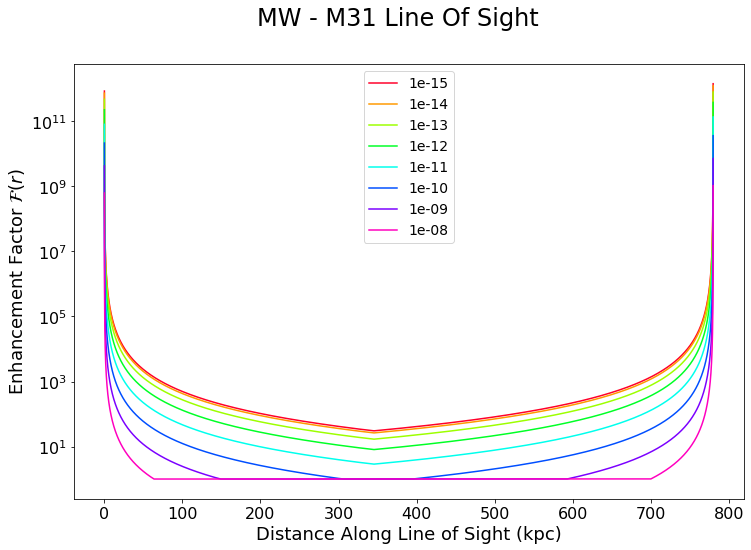

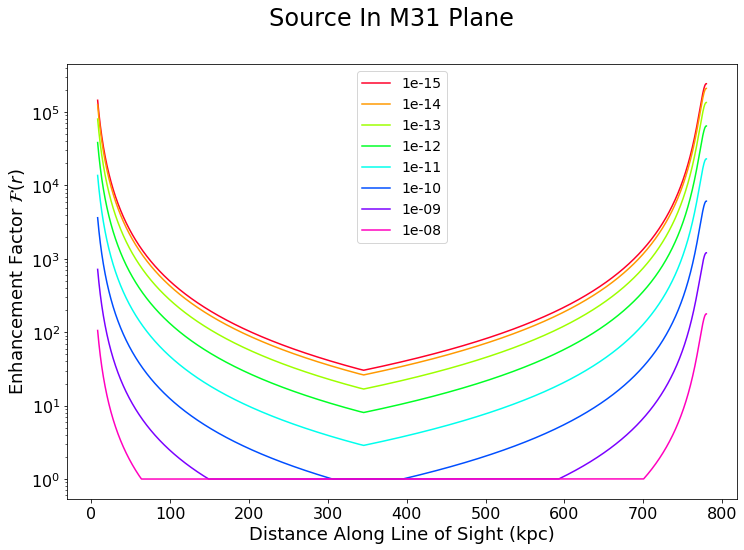

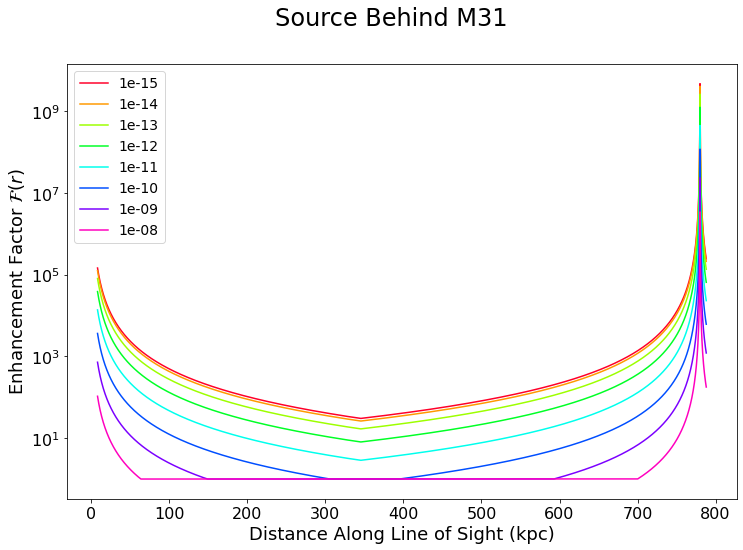

In [4]:
centerToCenterEventCalculator.plotEnhancement(title="MW - M31 Line Of Sight")
planarEventCalculator.plotEnhancement(title="Source In M31 Plane")
behindEventCalculator.plotEnhancement(title="Source Behind M31")

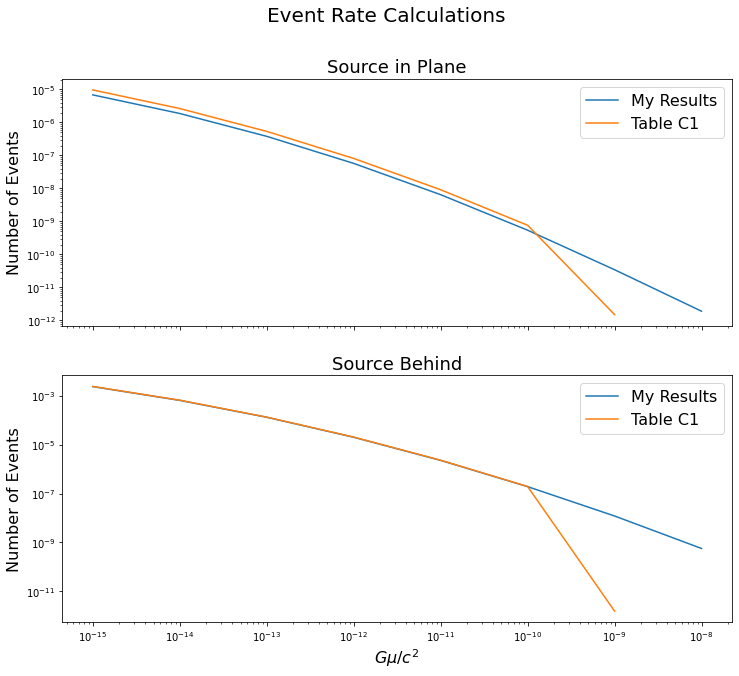

In [5]:
nEventsPlanar = (planarEventCalculator.results["eventRates"] * tObs).decompose()
nEventsBehind = (behindEventCalculator.results["eventRates"] * tObs).decompose()

fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
ys = [[nEventsPlanar, tableC1PlanarResults],
      [nEventsBehind, tableC1BackResults]]
labels = ["My Results", "Table C1"]
titles = ["Source in Plane", "Source Behind"]
for iax, (ax, t) in enumerate(zip(axs.ravel(), titles)):
    ax.set_title(t, fontsize=18)
    ax.set_ylabel("Number of Events", fontsize=16)
    for y, l, t in zip(ys[iax], labels, titles):
        ax.loglog(planarEventCalculator.tensions, y, label=l)
    ax.legend(fontsize=16)
axs[1].set_xlabel(r"$G\mu/c^2$", fontsize=16)
fig.suptitle("Event Rate Calculations", fontsize=20)
plt.show(fig)

In [6]:
planarExperimentParameters = dict(observingHoursPerNight = 10 * u.hr,
                                 hostGalaxySolidAngle = 3.167 * u.deg**2)
planarExperimentCalculator = ExperimentExpectationsCalculator(planarExperimentParameters,
                                                              planarEventCalculator)
planarExperimentCalculator.calculate()

No handles with labels found to put in legend.


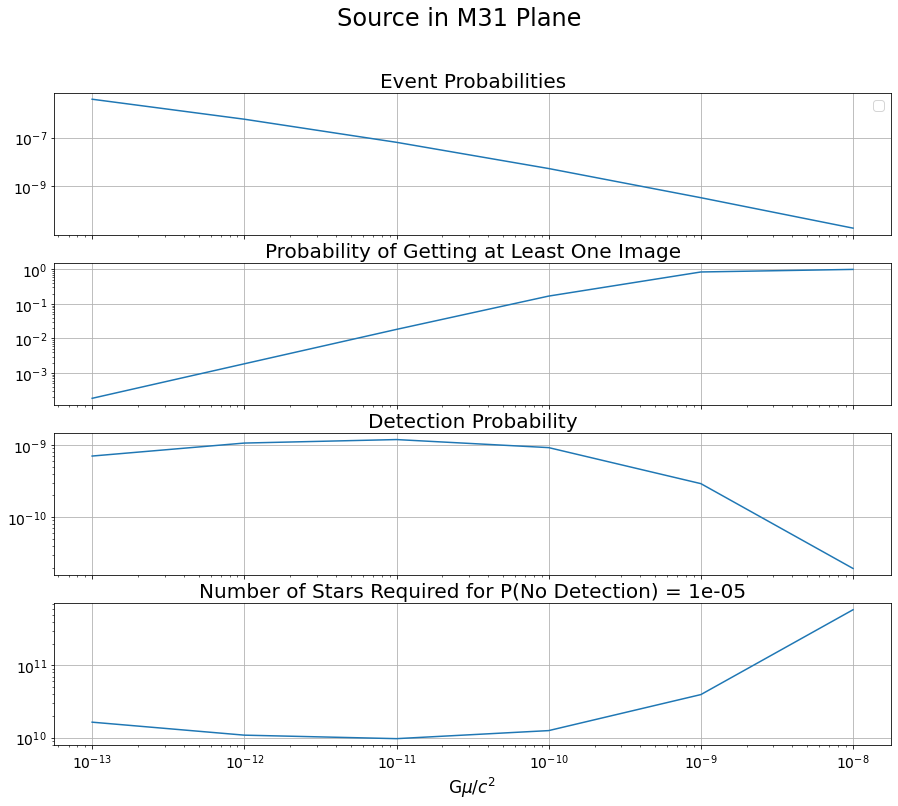

In [7]:
planarExperimentCalculator.plotResults(title="Source in M31 Plane")

ngc-300 Mass from [this paper](https://arxiv.org/pdf/1009.0317.pdf)

In [8]:
tensions = np.logspace(-15, -8, num=8)
curlyG = 1e4
mwHaloA = 1.15e9 * u.solMass / u.kpc**(3/4)
mwMass = 1.54e12 * u.solMass
observerPosition = np.array([0, 8]) * u.kpc
sourceBehind = np.array([8, 0]) * u.kpc
impactParameter = np.array([0, 0.1]) * u.kpc
nSteps = int(1e5)

lmcMassRatio = 10
lmcCenter = np.array([50, 0]) * u.kpc
lmcDistance = np.linalg.norm(lmcCenter)
lmcHaloR1, lmcHaloC = calculateHaloValues(lmcDistance, lmcMassRatio)

ngc300MassRatio = mwMass / (3.3e10 * u.solMass)
ngc300Center = np.array([1.86, 0]) * u.Mpc
ngc300Distance = np.linalg.norm(ngc300Center)
ngc300HaloR1, ngc300HaloC = calculateHaloValues(ngc300Distance, ngc300MassRatio)

lmcEventConfig = dict(tensions = tensions,
                      curlyG = curlyG,
                      dmHaloA = mwHaloA,
                      dmHaloC = lmcHaloC,
                      dmHaloR1 = lmcHaloR1,
                      hostGalaxyCenter = lmcCenter,
                      observerPosition = observerPosition,
                      sourcePosition = lmcCenter + sourceBehind,
                      impactParameter = impactParameter
                      )

ngc300EventConfig = dict(tensions = tensions,
                         curlyG = curlyG,
                         dmHaloA = mwHaloA,
                         dmHaloC = ngc300HaloC,
                         dmHaloR1 = ngc300HaloR1,
                         hostGalaxyCenter = ngc300Center,
                         observerPosition = observerPosition,
                         sourcePosition = ngc300Center + sourceBehind,
                         impactParameter = impactParameter
                         )

lmcEventCalculator = EventCalculator(lmcEventConfig)
ngc300EventCalculator = EventCalculator(ngc300EventConfig)

lmcEventCalculator.calculate(nSteps=nSteps)
ngc300EventCalculator.calculate(nSteps=nSteps)

In [9]:
observingHoursPerNight = 10 * u.hr
crowdedFieldExperimentDuration = 30 * u.day
crowdedFieldFilters = ["g", "r", "i", "z", "y"]
crowdedFieldVisits = np.array(5*[240])

lmcExperimentConfig = dict(observingHoursPerNight = observingHoursPerNight,
                           filters = crowdedFieldFilters,
                           visitsInEachFilter = crowdedFieldVisits,
                           experimentDuration = crowdedFieldExperimentDuration,
                           hostGalaxySolidAngle = 100 * u.deg**2
                           )

ngc300ExperimentConfig = dict(observingHoursPerNight = observingHoursPerNight,
                              filters = crowdedFieldFilters,
                              visitsInEachFilter = crowdedFieldVisits,
                              experimentDuration = crowdedFieldExperimentDuration,
                              hostGalaxySolidAngle = 21.9 * 15.5 * u.arcmin**2
                              )
lmcExperimentCalculator = ExperimentExpectationsCalculator(lmcExperimentConfig, lmcEventCalculator)

ngc300ExperimentCalculator = ExperimentExpectationsCalculator(ngc300ExperimentConfig, ngc300EventCalculator)

quantile = 0.1
lmcExperimentCalculator.calculate(quantile=quantile)
ngc300ExperimentCalculator.calculate(quantile=quantile)

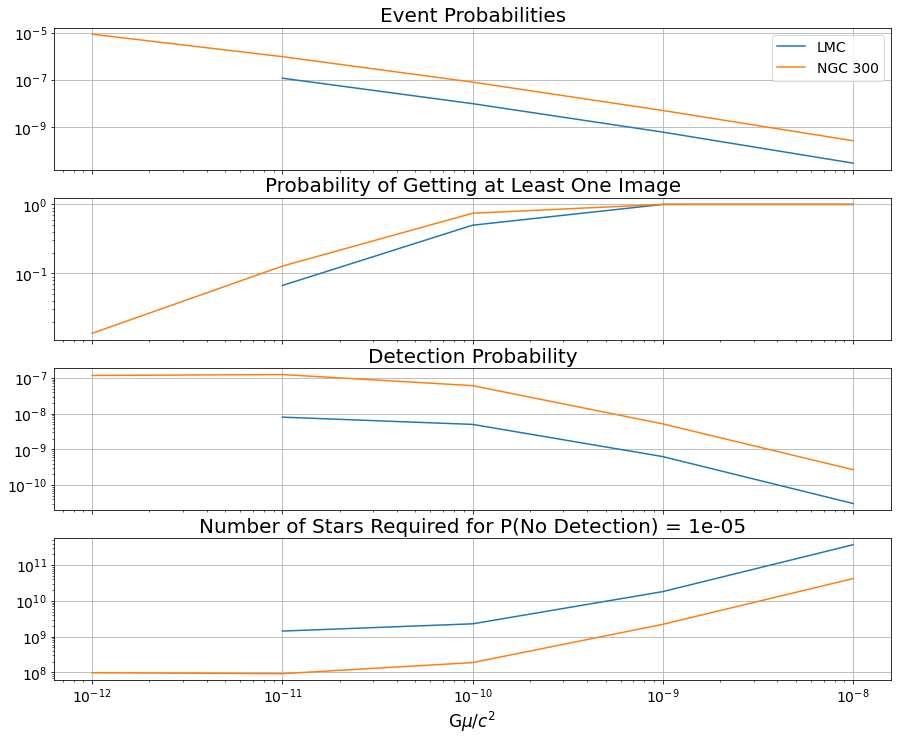

In [10]:
fig, axs = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

lmcExperimentCalculator.plotResults(figure=fig, show=False, label="LMC")
ngc300ExperimentCalculator.plotResults(figure=fig, label="NGC 300")

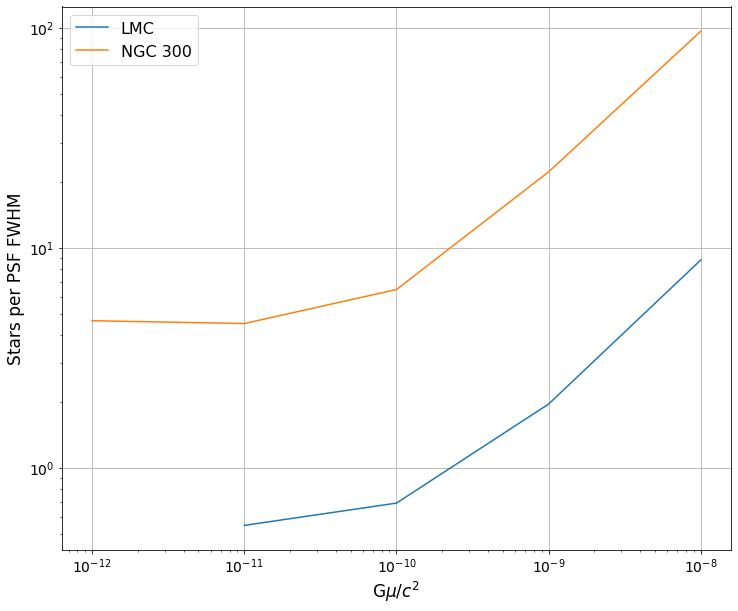

In [11]:
psfFWHM = 0.52 * u.arcsec
fig, ax = plt.subplots(figsize=(12, 10))
lmcExperimentCalculator.plotStarsPerPSF(psfFWHM, show=False, figure=fig, label="LMC")
ngc300ExperimentCalculator.plotStarsPerPSF(psfFWHM, figure=fig, label="NGC 300")

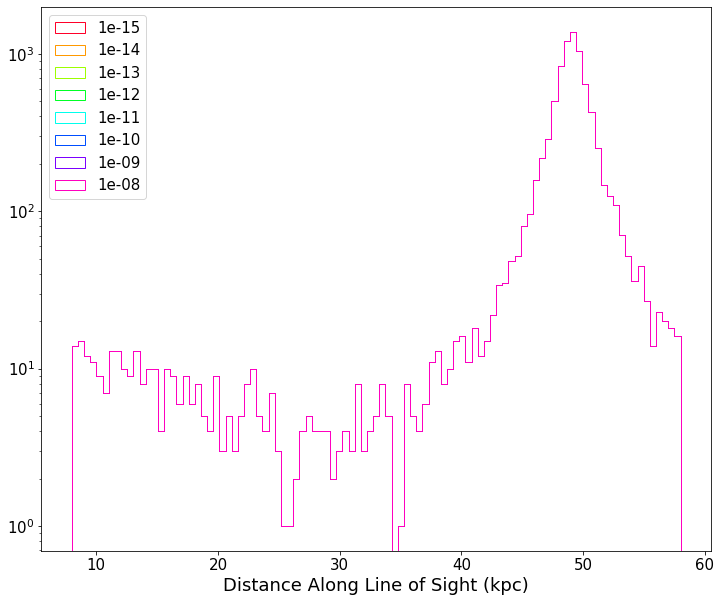

In [12]:
lmcDistanceSamples = lmcEventCalculator.sampleDistances(plot=True)

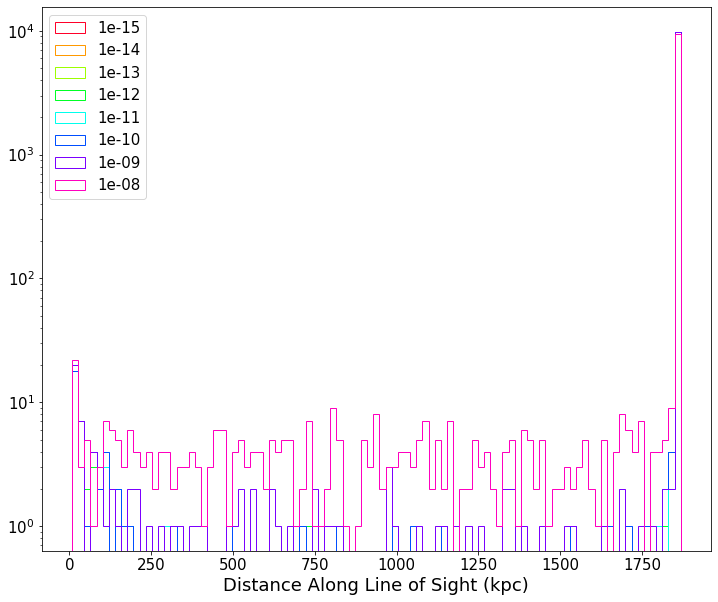

In [13]:
ngc300DistanceSamples = ngc300EventCalculator.sampleDistances(plot=True)

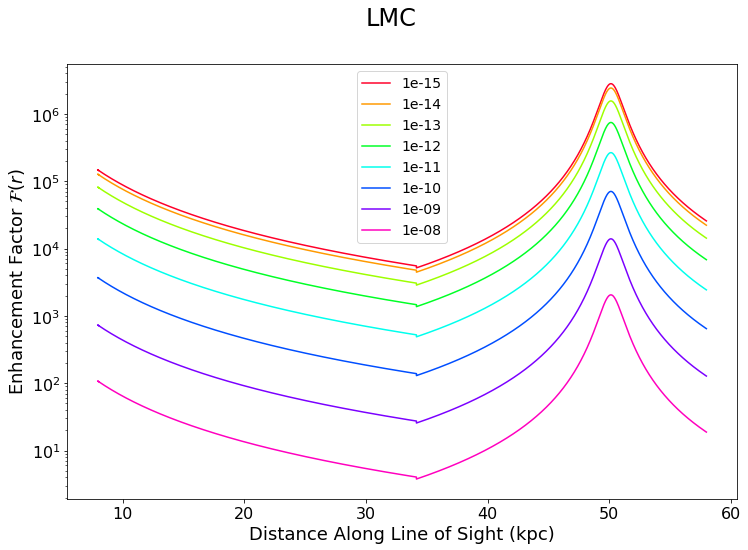

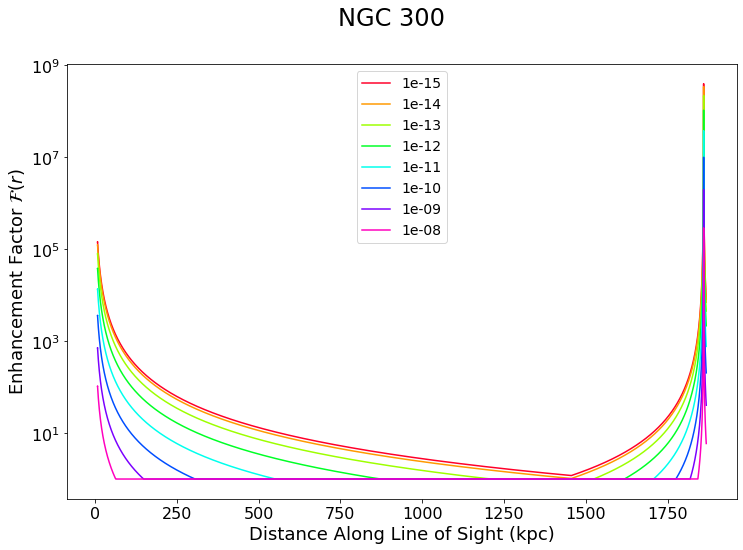

In [14]:
lmcEventCalculator.plotEnhancement(title="LMC")
ngc300EventCalculator.plotEnhancement(title="NGC 300")

In [15]:
lmcTimeSamples = lmcEventCalculator.computeLensingTimeSamples(lmcDistanceSamples)
ngc300TimeSamples = ngc300EventCalculator.computeLensingTimeSamples(ngc300DistanceSamples)

In [16]:
lmcMaxTimes = lmcEventCalculator.computeMaximumLensingTimes()
ngc300MaxTimes = ngc300EventCalculator.computeMaximumLensingTimes()

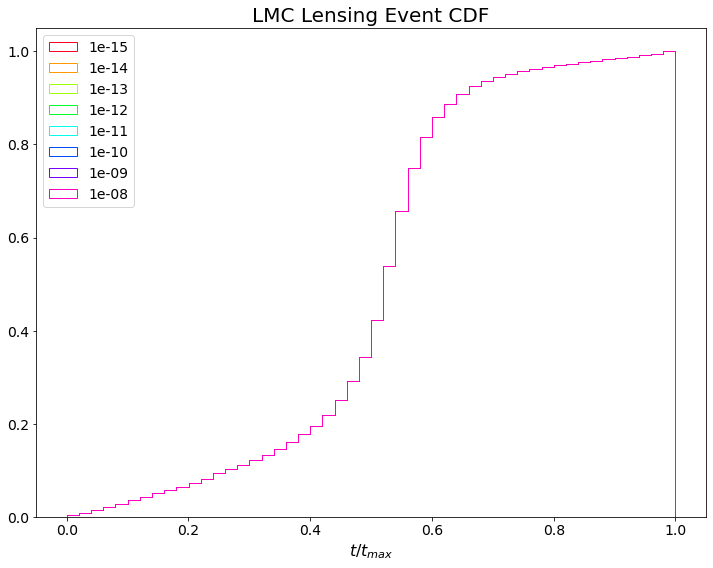

In [17]:
lmcFractionalTimes = lmcTimeSamples / lmcMaxTimes.reshape(8, 1)
colors = cm.gist_rainbow(np.linspace(0, 1, num=len(lmcEventCalculator.tensions)))
fig, ax = plt.subplots(figsize=(12, 9))
for ft, t, c in zip(lmcFractionalTimes.value, lmcEventCalculator.tensions, colors):
    ax.hist(ft, label=f"{t}", color=c, cumulative=True, density=True, bins=50, histtype="step")
ax.tick_params(labelsize=14)
ax.set_xlabel(r"$t/t_{max}$", fontsize=16)
ax.legend(loc="upper left", fontsize=14)
ax.set_title("LMC Lensing Event CDF", fontsize=20)
plt.show(fig)

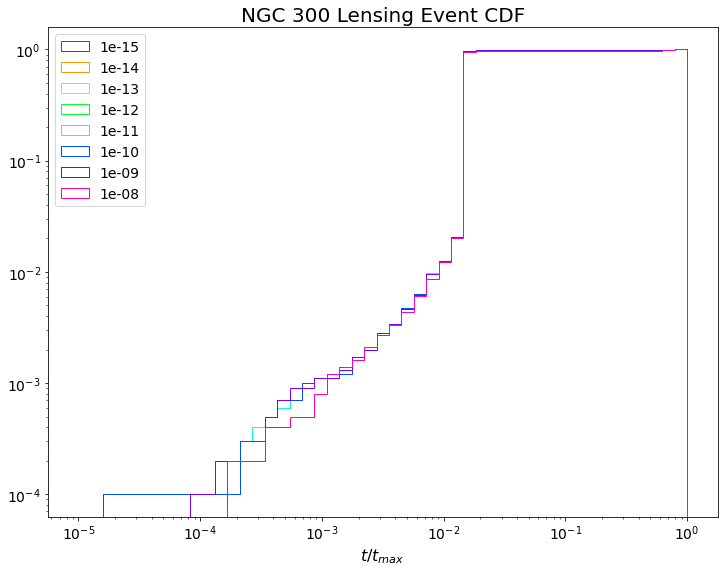

In [18]:
ngc300FractionalTimes = (ngc300TimeSamples / ngc300MaxTimes.reshape(8, 1)).decompose()
colors = cm.gist_rainbow(np.linspace(0, 1, num=len(ngc300EventCalculator.tensions)))
fig, ax = plt.subplots(figsize=(12, 9))

bins = np.logspace(-5, 0, num=50)

for ft, t, c in zip(ngc300FractionalTimes.value, ngc300EventCalculator.tensions, colors):
    ax.hist(ft, label=f"{t}", color=c, cumulative=True, density=True, bins=bins, histtype="step", log=True)
ax.tick_params(labelsize=14)
ax.set_xlabel(r"$t/t_{max}$", fontsize=16)
ax.set_xscale("log")
ax.legend(loc="upper left", fontsize=14)
ax.set_title("NGC 300 Lensing Event CDF", fontsize=20)
plt.show(fig)